<div class='heading'>
    <div style='float:left;'><h1>Project: ChatGPT Some Trained Models 3.5 and 4</h1>
        <h3>ipynb file: Annotation with some training.ipynb</h3>
        <h4>**Clemson University**<br>
        <h5>To use this notebook, .env file must be in the directory you start juypter lab</h5>
        <h5>Make sure you install dependencies
                pip install openai python-dotenv</h5></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
    



---

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [1]:
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
import numpy as np
import time
import glob
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load up the API Keys for GPT

load_dotenv()

my_id = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    api_key=os.environ.get("my_id"),
)

In [3]:
# Define a module to do the GPT call this way we don't have to call it everytime we want to test something
def Annotate_data(df):

    #initialize varibles for this module
    
    results = []
    temp = []
    out_prompt = []
    in_prompt = df['Prompt']

    #default the temp for the OpenAI call
    temperature_value = 0.25

    prompt = f"""Given a URL, analyze and classify it as phishing or legitimate by examining several key aspects.
    First, evaluate URL-based features such as the use of IP addresses, the length of the URL, the presence of HTTPS, the number of dots, and the use of shortening services. 
    Second, inspect content-based features by loading the webpage, if safe, to check for the presence of form tags, the ratio of internal to external links, and the use of external resources like CSS files. 
    Third, consult external services to assess the domain age, its WHOIS registration details, and its presence in known phishing databases.
    For each feature, apply the following reasoning:

    URL Length: Longer URLs are often used to deceive users by hiding malicious parts.

    HTTPS Presence: The absence of HTTPS may indicate a lack of security, though its presence alone does not guarantee legitimacy.

    Please classify the following url as legitimate, phishing, or unknown without invoking the website. Provide the classification and reasoning:\n{in_prompt}\n"""

    retries = 1
    while retries > 0:
        try:
            start = time.time()

            response = client.chat.completions.create(
                model='gpt-4',
                #model='gpt-3.5-turbo',
                temperature=temperature_value,
                messages=[
                    {"role": "system", "content": "You are a skilled security expert"},
                    {"role": "user", "content": prompt}
                      ],
                max_tokens=30,
            )

            print ("-----\n")    
            print (response)
                
            results.append(response.choices[0].message.content.strip())
            temp.append(temperature_value)
            out_prompt.append(in_prompt)

            break  # Exit the retry loop if the request is successful

        except Exception as e:
            
            print(f"Error: {e}")
            
            # we add delay to avoid having the model overloaded
            retries -= 1
            time.sleep(10)  # Wait for 10 seconds before retrying

    # Add the results as a new column to the DataFrame
    df1 = pd.DataFrame()
    
    df1['Prompt'] = out_prompt
    df1['BaseLabel'] = df['BaseLabel']
    df1['Legit'] = results
    df1['Phish'] = 0
    df1['Unknown'] = 0
    df1['Temp'] = temp
    df1['ElapsedTime'] = round(time.time() - start, 3)

    return (df1)

In [4]:
#Build the list of files to read into a single DF

prompt_files = sorted(glob.glob('/Users/roulierk/Documents/Clemson/Thesis/Code/Kaggle Phish Data/test_prompt*.csv'))

prompt_df = pd.DataFrame()
                             
for file in prompt_files:
    temp_df = pd.read_csv(file, 
        sep=',',
        error_bad_lines=False,
        header=None)
        
    temp_df.columns=(['Prompt', 'BaseLabel', 'Legit', 'Phish', 'Unknown', 'Temp', 'ElapsedTime'])
        
    prompt_df = pd.concat([prompt_df, temp_df], ignore_index=True)
display (prompt_df)

,Prompt,BaseLabel,Legit,Phish,Unknown,Temp,ElapsedTime
0,https://my-project-1-6316.ue.r.appspot.com/,1.0,NaN,NaN,NaN,0,0
1,http://www.dmega.co.kr/dmega/data/qna/sec/page...,1.0,NaN,NaN,NaN,0,0
2,http://www.ebpnovin.com/,0.0,NaN,NaN,NaN,0,0
3,http://www.decaturilbgc.com/ckeditor/themes/de...,1.0,NaN,NaN,NaN,0,0
4,https://dawg.jp/slam/Webmail,1.0,NaN,NaN,NaN,0,0
5,https://firebasestorage.googleapis.com/v0/b/io...,1.0,NaN,NaN,NaN,0,0
6,http://regiscoyne.com/368762BDB30FAB1003AAB48B...,1.0,NaN,NaN,NaN,0,0
7,http://78.143.96.35/wordpress/gam/index.php?bi...,1.0,NaN,NaN,NaN,0,0
8,http://www.totallandscapecare.com/landscaping/...,0.0,NaN,NaN,NaN,0,0
9,https://www.onecklace.com/fingerprint-jewelry/,0.0,NaN,NaN,NaN,0,0


# ==== Only need to run the next block if you want to call GPT ========

In [5]:
#Call GPT engine to build the working DFs

chat_df = pd.DataFrame()
result_df = pd.DataFrame()
    
for ind in prompt_df.index:
    chat_df = Annotate_data(prompt_df.iloc[ind])
    
    print ("=================\n")
    print (chat_df.Legit)

    if (chat_df.Legit.str.contains('Legit').bool()) | (chat_df.Legit.str.contains('legit').bool()): 
            chat_df.Legit = 1
    elif (chat_df.Legit.str.contains('Phish').bool()) | (chat_df.Legit.str.contains('phish').bool()): 
            chat_df.Phish = 1
    else : 
            chat_df.Unknown = 1
            
    chat_df.loc[chat_df['Legit'] != 1, "Legit"] = 0
    chat_df.loc[chat_df['Unknown'] != 1, "Unknown"] = 0
    chat_df.loc[chat_df['Phish'] != 1, "Phish"] = 0
    
    chat_df["Legit"] = chat_df["Legit"].astype(float)    
    chat_df["Phish"] = chat_df["Phish"].astype(float)    
    chat_df["Unknown"] = chat_df["Unknown"].astype(float)
    print (chat_df.Legit, "\n")
    print (chat_df.Phish, "\n")
    print (chat_df.Unknown, "\n")
        
    result_df = result_df.append(chat_df, ignore_index = True)

-----

ChatCompletion(id='chatcmpl-AJj22y16qwh8rDCkLgB6JTlXFMUNf', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content="Classification: Unknown\n\nReasoning: \n\n1. URL Length: The URL is not excessively long, which is a good sign. However, it's", role='assistant', function_call=None, tool_calls=None, refusal=None))], created=1729264698, model='gpt-4-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=30, prompt_tokens=234, total_tokens=264, prompt_tokens_details={'cached_tokens': 0}, completion_tokens_details={'reasoning_tokens': 0}))

0    Classification: Unknown\n\nReasoning: \n\n1. U...
Name: Legit, dtype: object
0    0.0
Name: Legit, dtype: float64 

0    0.0
Name: Phish, dtype: float64 

0    1.0
Name: Unknown, dtype: float64 

-----

ChatCompletion(id='chatcmpl-AJj24qHliZMjYYuGGHx4uVuLXvx3S', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage

# Code from here on is to visualize results

In [6]:
result_df.info()
display (result_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Prompt       10 non-null     object 
 1   BaseLabel    10 non-null     float64
 2   Legit        10 non-null     float64
 3   Phish        10 non-null     float64
 4   Unknown      10 non-null     float64
 5   Temp         10 non-null     float64
 6   ElapsedTime  10 non-null     float64
dtypes: float64(6), object(1)
memory usage: 688.0+ bytes


,Prompt,BaseLabel,Legit,Phish,Unknown,Temp,ElapsedTime
0,https://my-project-1-6316.ue.r.appspot.com/,1.0,0.0,0.0,1.0,0.25,2.467
1,http://www.dmega.co.kr/dmega/data/qna/sec/page...,1.0,0.0,1.0,0.0,0.25,2.017
2,http://www.ebpnovin.com/,0.0,0.0,0.0,1.0,0.25,2.029
3,http://www.decaturilbgc.com/ckeditor/themes/de...,1.0,0.0,1.0,0.0,0.25,1.832
4,https://dawg.jp/slam/Webmail,1.0,0.0,0.0,1.0,0.25,1.623
5,https://firebasestorage.googleapis.com/v0/b/io...,1.0,0.0,1.0,0.0,0.25,1.725
6,http://regiscoyne.com/368762BDB30FAB1003AAB48B...,1.0,0.0,1.0,0.0,0.25,1.505
7,http://78.143.96.35/wordpress/gam/index.php?bi...,1.0,0.0,1.0,0.0,0.25,1.940
8,http://www.totallandscapecare.com/landscaping/...,0.0,1.0,0.0,0.0,0.25,2.759
9,https://www.onecklace.com/fingerprint-jewelry/,0.0,0.0,0.0,1.0,0.25,1.652


In [7]:
printdf = result_df.cumsum()
display (printdf)

,Prompt,BaseLabel,Legit,Phish,Unknown,Temp,ElapsedTime
0,https://my-project-1-6316.ue.r.appspot.com/,1.0,0.0,0.0,1.0,0.25,2.467
1,https://my-project-1-6316.ue.r.appspot.com/htt...,2.0,0.0,1.0,1.0,0.50,4.484
2,https://my-project-1-6316.ue.r.appspot.com/htt...,2.0,0.0,1.0,2.0,0.75,6.513
3,https://my-project-1-6316.ue.r.appspot.com/htt...,3.0,0.0,2.0,2.0,1.00,8.345
4,https://my-project-1-6316.ue.r.appspot.com/htt...,4.0,0.0,2.0,3.0,1.25,9.968
5,https://my-project-1-6316.ue.r.appspot.com/htt...,5.0,0.0,3.0,3.0,1.50,11.693
6,https://my-project-1-6316.ue.r.appspot.com/htt...,6.0,0.0,4.0,3.0,1.75,13.198
7,https://my-project-1-6316.ue.r.appspot.com/htt...,7.0,0.0,5.0,3.0,2.00,15.138
8,https://my-project-1-6316.ue.r.appspot.com/htt...,7.0,1.0,5.0,3.0,2.25,17.897
9,https://my-project-1-6316.ue.r.appspot.com/htt...,7.0,1.0,5.0,4.0,2.50,19.549


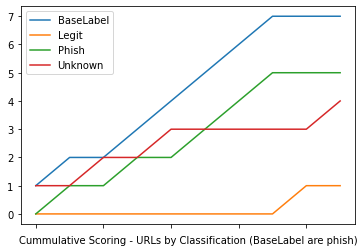

In [8]:
printdf.plot(x="Prompt", y=["BaseLabel", "Legit", "Phish", "Unknown"], xlabel="URLs")
plt.gca().set_xticklabels([])
plt.xlabel("Cummulative Scoring - URLs by Classification (BaseLabel are phish)")
plt.show()

In [9]:
printdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Prompt       10 non-null     object 
 1   BaseLabel    10 non-null     float64
 2   Legit        10 non-null     float64
 3   Phish        10 non-null     float64
 4   Unknown      10 non-null     float64
 5   Temp         10 non-null     float64
 6   ElapsedTime  10 non-null     float64
dtypes: float64(6), object(1)
memory usage: 688.0+ bytes
